In [30]:
import os
import shutil
import copy
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
import torch
from torchvision import datasets , transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [2]:
src_path = "/kaggle/input/animals10/raw-img"
path = "/kaggle/working/raw-img"

shutil.copytree(src_path, path, dirs_exist_ok=True)

'/kaggle/working/raw-img'

In [3]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant",
             "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat",
             "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
classes = os.listdir(path)

In [4]:
for category in classes:
    category_path = os.path.join(path, category)
    if os.path.isdir(category_path):
        eng_name = translate.get(category, category)
        eng_path = os.path.join(path, eng_name)
        if eng_name != category:
            os.rename(category_path, eng_path)

In [5]:
dataset = datasets.ImageFolder(root=path)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 26179
    Root location: /kaggle/working/raw-img


In [6]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
test_size = int(0.2 * dataset_size)
val_size = dataset_size - train_size - test_size

In [7]:
train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])

In [8]:
temp_dataset = datasets.ImageFolder(root=path, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))

In [9]:
def get_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    for images, _ in loader:
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(dataset)
    std /= len(dataset)
    return mean, std

In [11]:
mean, std = get_mean_std(temp_dataset)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.5177, 0.5003, 0.4126])
Std: tensor([0.2133, 0.2130, 0.2149])


In [12]:
def get_transform(aug_type="light"):
    if aug_type == "light":
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])
    elif aug_type == "heavy":
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(30),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5177, 0.5003, 0.4126), (0.2133, 0.2130, 0.2149)),
        ])


In [13]:
def update_dataloaders(train_transform, val_transform):
    train_dataset_aug = Subset(datasets.ImageFolder(root=path, transform=train_transform), train_dataset.indices)
    val_dataset_aug = Subset(datasets.ImageFolder(root=path, transform=val_transform), val_dataset.indices)

    train_dl = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_dataset_aug, batch_size=batch_size*2, shuffle=False, num_workers=4, pin_memory=True)

    return train_dl, val_dl

In [18]:
batch_size = 128
test_dataset = Subset(datasets.ImageFolder(root=path, transform=get_transform()), test_dataset.indices)
test_dl = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [14]:
class ModelCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ModelCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.conv1x1 = nn.Conv2d(256, 256, kernel_size=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = F.relu(self.conv1x1(x))

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)

        return x

In [36]:
def train_model(model, train_dl, val_dl, device, optimizer, epochs=10):
    loss_function = nn.CrossEntropyLoss()
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_dl)
        epoch_acc = running_corrects / len(train_dl.dataset)
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc)

        model.eval()
        val_loss, val_corrects = 0.0, 0
        with torch.no_grad():
            for val_inputs, val_labels in val_dl:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = loss_function(val_outputs, val_labels)
                _, val_preds = torch.max(val_outputs, 1)
                val_loss += loss.item()
                val_corrects += torch.sum(val_preds == val_labels.data).item()

        val_epoch_loss = val_loss / len(val_dl)
        val_epoch_acc = val_corrects / len(val_dl.dataset)
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")
        
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

In [43]:
def evaluate_model(model, test_dl, device):
    model.eval()
    all_preds, all_labels = [], []
    class_names = dataset.classes

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = ModelCNN().to(device)

In [39]:
print("\nStage 1: Light aug + LR 0.001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
train_dl_stage1, val_dl_stage1 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn, history1 = train_model(cnn, train_dl_stage1, val_dl_stage1, device, optimizer, epochs=15)

print("\nStage 2: Heavy aug + LR 0.001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
train_dl_stage2, val_dl_stage2 = update_dataloaders(get_transform("heavy"), get_transform("heavy"))
cnn, history2 = train_model(cnn, train_dl_stage2, val_dl_stage2, device, optimizer, epochs=30)

print("\nStage 3: Light aug again + LR 0.001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
train_dl_stage3,val_dl_stage3 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn, history3 = train_model(cnn, train_dl_stage3, val_dl_stage3, device, optimizer, epochs=10)


Stage 1: Light aug + LR 0.001
Epoch 1/15 | Train Loss: 1.7041 | Train Acc: 0.4019 | Val Loss: 1.4732 | Val Acc: 0.5048
Epoch 2/15 | Train Loss: 1.2669 | Train Acc: 0.5664 | Val Loss: 1.2222 | Val Acc: 0.6025
Epoch 3/15 | Train Loss: 1.0709 | Train Acc: 0.6318 | Val Loss: 1.2392 | Val Acc: 0.5811
Epoch 4/15 | Train Loss: 0.9433 | Train Acc: 0.6779 | Val Loss: 1.1073 | Val Acc: 0.6308
Epoch 5/15 | Train Loss: 0.8449 | Train Acc: 0.7130 | Val Loss: 1.0178 | Val Acc: 0.6808
Epoch 6/15 | Train Loss: 0.7467 | Train Acc: 0.7495 | Val Loss: 0.9000 | Val Acc: 0.7251
Epoch 7/15 | Train Loss: 0.6722 | Train Acc: 0.7721 | Val Loss: 0.8291 | Val Acc: 0.7300
Epoch 8/15 | Train Loss: 0.6021 | Train Acc: 0.7978 | Val Loss: 0.8413 | Val Acc: 0.7362
Epoch 9/15 | Train Loss: 0.5356 | Train Acc: 0.8170 | Val Loss: 0.8243 | Val Acc: 0.7384
Epoch 10/15 | Train Loss: 0.4805 | Train Acc: 0.8387 | Val Loss: 0.9788 | Val Acc: 0.7045
Epoch 11/15 | Train Loss: 0.4185 | Train Acc: 0.8602 | Val Loss: 0.8655 | Val 

Test Accuracy: 0.8581
F1 Score (weighted): 0.8587
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.90      0.86      0.88       430
         cat       0.81      0.83      0.82       352
     chicken       0.94      0.85      0.89       617
         cow       0.74      0.80      0.77       387
         dog       0.86      0.85      0.85       996
    elephant       0.85      0.88      0.87       286
       horse       0.84      0.86      0.85       492
       sheep       0.83      0.79      0.81       370
      spider       0.93      0.92      0.92       927
    squirrel       0.76      0.87      0.81       378

    accuracy                           0.86      5235
   macro avg       0.85      0.85      0.85      5235
weighted avg       0.86      0.86      0.86      5235



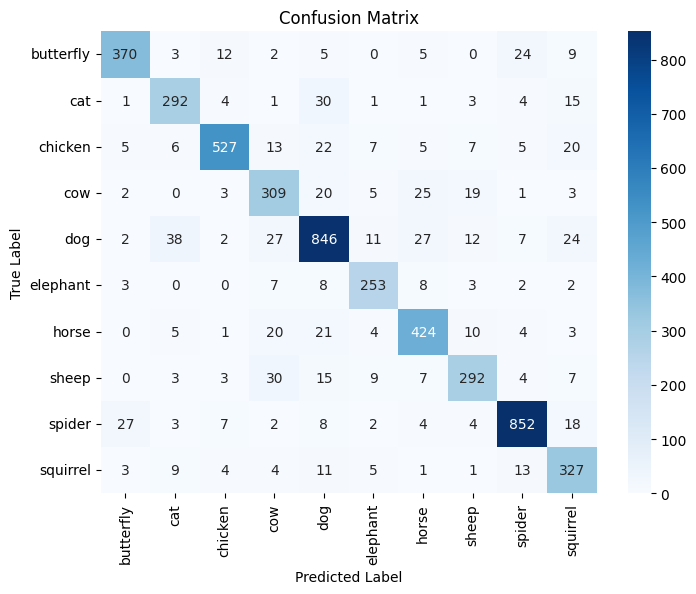

In [44]:
evaluate_model(cnn, test_dl, device)

In [45]:
print("\nStage 4: Light aug again + LR 0.00001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.00001)
train_dl_stage4,val_dl_stage4 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn, history4 = train_model(cnn, train_dl_stage4, val_dl_stage4, device, optimizer, epochs=10)


Stage 4: Light aug again + LR 0.00001
Epoch 1/10 | Train Loss: 0.1580 | Train Acc: 0.9478 | Val Loss: 0.4842 | Val Acc: 0.8675
Epoch 2/10 | Train Loss: 0.1421 | Train Acc: 0.9525 | Val Loss: 0.4632 | Val Acc: 0.8721
Epoch 3/10 | Train Loss: 0.1381 | Train Acc: 0.9548 | Val Loss: 0.4604 | Val Acc: 0.8744
Epoch 4/10 | Train Loss: 0.1289 | Train Acc: 0.9582 | Val Loss: 0.4716 | Val Acc: 0.8748
Epoch 5/10 | Train Loss: 0.1256 | Train Acc: 0.9579 | Val Loss: 0.4583 | Val Acc: 0.8736
Epoch 6/10 | Train Loss: 0.1227 | Train Acc: 0.9592 | Val Loss: 0.4571 | Val Acc: 0.8813
Epoch 7/10 | Train Loss: 0.1211 | Train Acc: 0.9607 | Val Loss: 0.4746 | Val Acc: 0.8725
Epoch 8/10 | Train Loss: 0.1221 | Train Acc: 0.9591 | Val Loss: 0.4564 | Val Acc: 0.8767
Epoch 9/10 | Train Loss: 0.1142 | Train Acc: 0.9621 | Val Loss: 0.4618 | Val Acc: 0.8782
Epoch 10/10 | Train Loss: 0.1114 | Train Acc: 0.9626 | Val Loss: 0.4588 | Val Acc: 0.8793


Test Accuracy: 0.8758
F1 Score (weighted): 0.8753
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.90      0.87      0.89       430
         cat       0.87      0.80      0.83       352
     chicken       0.89      0.90      0.89       617
         cow       0.81      0.79      0.80       387
         dog       0.85      0.91      0.88       996
    elephant       0.89      0.89      0.89       286
       horse       0.86      0.86      0.86       492
       sheep       0.85      0.77      0.81       370
      spider       0.93      0.94      0.94       927
    squirrel       0.86      0.85      0.86       378

    accuracy                           0.88      5235
   macro avg       0.87      0.86      0.86      5235
weighted avg       0.88      0.88      0.88      5235



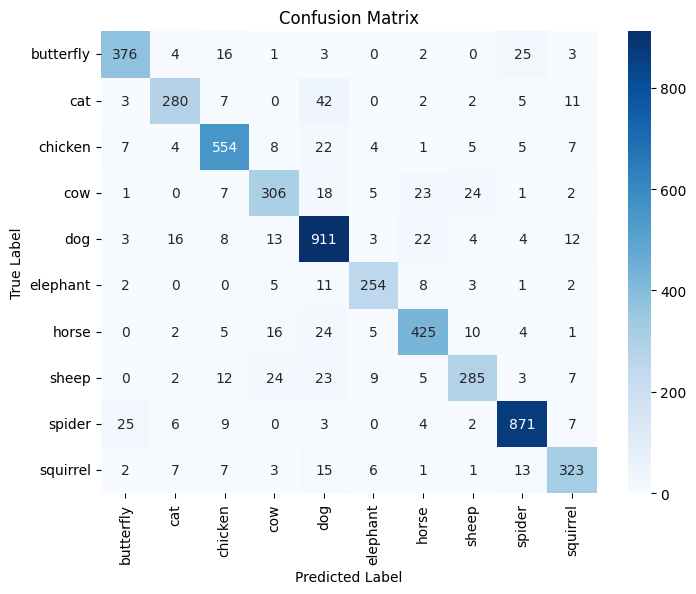

In [46]:
evaluate_model(cnn, test_dl, device)

**Nothing has improved for stage 5 (results below), so only 4 stages remains.**

In [48]:
print("\nStage 5: Light aug again + LR 0.000001")
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.000001)
train_dl_stage5,val_dl_stage5 = update_dataloaders(get_transform("light"), get_transform("light"))
cnn1, history5 = train_model(cnn2, train_dl_stage5, val_dl_stage5, device, optimizer, epochs=5)


Stage 5: Light aug again + LR 0.000001
Epoch 1/5 | Train Loss: 0.0728 | Train Acc: 0.9767 | Val Loss: 0.8433 | Val Acc: 0.8488
Epoch 2/5 | Train Loss: 0.0682 | Train Acc: 0.9781 | Val Loss: 0.8328 | Val Acc: 0.8534
Epoch 3/5 | Train Loss: 0.0704 | Train Acc: 0.9783 | Val Loss: 0.8145 | Val Acc: 0.8557
Epoch 4/5 | Train Loss: 0.0645 | Train Acc: 0.9795 | Val Loss: 0.8201 | Val Acc: 0.8541
Epoch 5/5 | Train Loss: 0.0706 | Train Acc: 0.9769 | Val Loss: 0.7982 | Val Acc: 0.8503


Test Accuracy: 0.8758
F1 Score (weighted): 0.8754
Classification Report:
              precision    recall  f1-score   support

   butterfly       0.90      0.87      0.89       430
         cat       0.85      0.80      0.83       352
     chicken       0.89      0.91      0.90       617
         cow       0.81      0.77      0.79       387
         dog       0.86      0.90      0.88       996
    elephant       0.89      0.88      0.89       286
       horse       0.85      0.87      0.86       492
       sheep       0.82      0.79      0.80       370
      spider       0.94      0.95      0.94       927
    squirrel       0.88      0.85      0.86       378

    accuracy                           0.88      5235
   macro avg       0.87      0.86      0.86      5235
weighted avg       0.88      0.88      0.88      5235



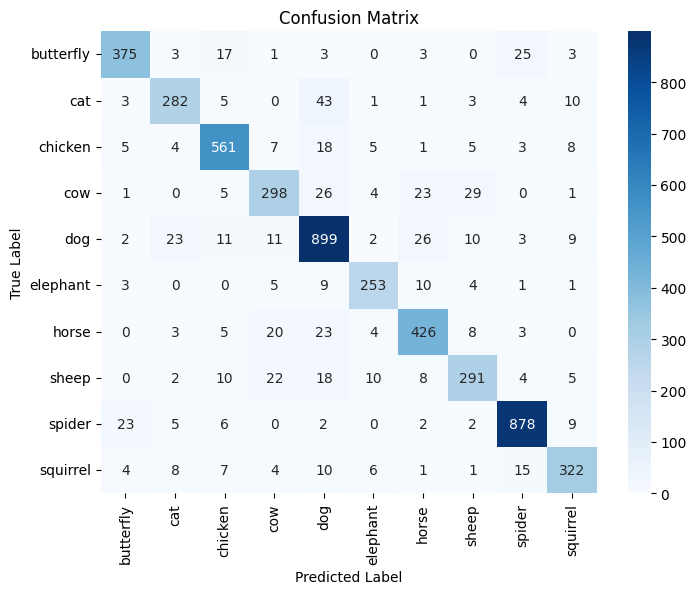

In [49]:
evaluate_model(cnn, test_dl, device)

In [53]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for hist in [history1, history2, history3, history4]:
    for key in history:
        history[key].extend(hist[key])

In [51]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].plot(history['train_loss'], label='Train Loss')
    ax[0].plot(history['val_loss'], label='Val Loss')
    ax[0].set_title('Loss per Epoch')
    ax[0].legend()

    ax[1].plot(history['train_acc'], label='Train Acc')
    ax[1].plot(history['val_acc'], label='Val Acc')
    ax[1].set_title('Accuracy per Epoch')
    ax[1].legend()


    plt.show()

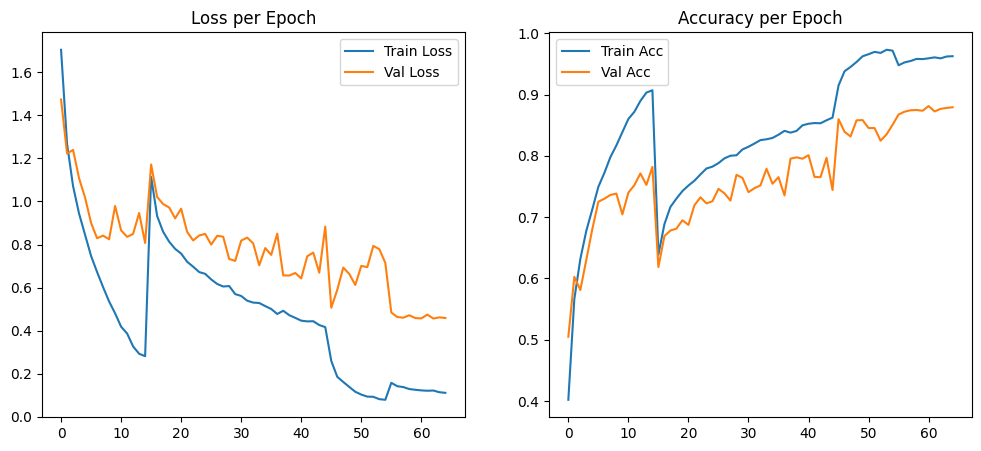

In [54]:
plot_training_history(history)

In [55]:
def show_misclassified_images(model, dataloader, class_names, device, max_images=10):
    model.eval()
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    misclassified_images.append(img.cpu())
                    misclassified_preds.append(pred.cpu())
                    misclassified_labels.append(label.cpu())

                if len(misclassified_images) >= max_images:
                    break
            if len(misclassified_images) >= max_images:
                break

    plt.figure(figsize=(15, 5))
    for i in range(len(misclassified_images)):
        plt.subplot(1, len(misclassified_images), i + 1)
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())
        plt.imshow(img)
        plt.title(f"True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

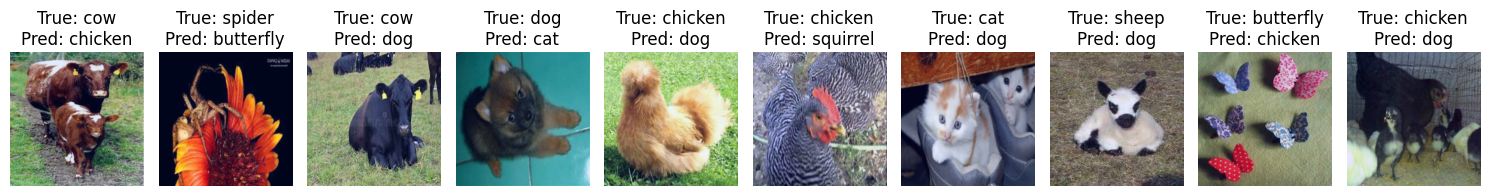

In [57]:
show_misclassified_images(cnn, val_dl_stage4, dataset.classes, device)

**Conclusion:**
several additional layers were added to the model and the dropout was increased. The training was based on the following pipeline:

15 epochs on easily augmented data

30 epochs on hardly augmented data

10 epochs on easy augmented data

then there were further attempts to train on lightly aggregated data, but with a larger learning rate:

10 epochs with lr 0.00001

further attempts to reduce the learning rate did not yield better results.  


**Test Accuracy: 0.8758; F1 Score (weighted): 0.8753**


In [58]:
new_path = '/kaggle/working/better-cnn-animal10.pth'
torch.save(cnn.state_dict(), new_path)